In [1]:
import os
import torch
from torch import nn
from poutyne import Model, CSVLogger
from poutyne.framework import ModelCheckpoint, EarlyStopping, plot_history
import numpy as np
import torchmetrics
from datetime import datetime
import sys
import pandas as pd
from custom_lib.custom_models.basic_nn import NeuralNetwork
from custom_lib.data_prep import data_transformation_pipeline, data_loader
import matplotlib as plt
import torchvision.models as models
import time


In [2]:
# Tuneable Params
lr = 1e-3
data_dir = "data_2_class"
model_name = "truncated_b0" 
image_size = 224
center_crop = 224
seed = 42
batch_size = 32
results_folder_name = "test"
truncated_layers = 3
bootstrap_n = None
pretrained = True
dropout_p = .2
model_path = "tb_results2/truncated_b0_reduced_layers_3_2025-03-05_09-16/final_model.pth"





In [3]:
torch.manual_seed(seed)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

# Get class names
external_test_dataset = ImageFolder(data_dir)  # Load without transformations just to access class names
class_names = external_test_dataset.classes


# Define transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(center_crop),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # transforms.GaussianBlur(kernel_size=9, sigma=5)
])

# Apply transformations to dataset
testset = ImageFolder(data_dir, transform=transform)

# Create DataLoader
test_loader = DataLoader(
    testset, batch_size=batch_size * 2, num_workers=4, pin_memory=True, drop_last=True
)


In [6]:
num_classes = len(class_names)

In [7]:
import importlib

def load_model(model_name, **kwargs):
    """Dynamically loads and instantiates a model from custom_lib.custom_models."""
    module = importlib.import_module(f"custom_lib.custom_models.{model_name}")
    
    # Find the first class in the module (assuming only one model class per file)
    model_class = getattr(module, model_name, None)
    
    if model_class is None:
        raise ValueError(f"Could not find a class named '{model_name}' in '{module.__name__}'")

    return model_class(**kwargs)


model = load_model(
    model_name,
    num_classes=num_classes,
    removed_layers=truncated_layers,
    batch_size=batch_size,
    image_size=image_size,
    pretrained=pretrained,
    dropout_p=dropout_p
)


In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau




# 6. Wrap the model with Poutyne
poutyne_model = Model(
    model,
    # optimizer=torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9),  # Added momentum

    optimizer=torch.optim.Adam(model.parameters(), lr=lr),
    loss_function=nn.CrossEntropyLoss(),
    batch_metrics=["accuracy"],
    device=device
)

In [9]:


# Load the state dict into the model
poutyne_model.network.load_state_dict(torch.load(model_path))


/var/folders/gw/q9_8w8jn0js6k5m5d98vhhcdzkx593/T/ipykernel_13303/3377538203.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  poutyne_model.network.load_state_dict(torch.l

<All keys matched successfully>

In [10]:
# from custom_lib.bootstrap import bootstrap_evaluation_poutyne

# # Evaluate using Poutyne
# test_loss, test_acc = poutyne_model.evaluate_generator(test_loader)


# boot_strap_results = bootstrap_evaluation_poutyne(poutyne_model, test_loader, n_bootstraps = bootstrap_n, save_logs=True, 
#                                                   results_dir=results_dir, seed=seed)



In [11]:
testset.classes

['NORMAL', 'TB']

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, recall_score
from torch.utils.data import DataLoader
from poutyne import Model

def evaluate_tb_class(model, test_loader, tb_class_index):
    """
    Evaluates the sensitivity and specificity for the TB class.
    
    Args:
        model: The trained Poutyne model.
        test_loader: DataLoader for the test dataset.
        tb_class_index: The index of the TB class in the class_names list.
        
    Returns:
        A dictionary with sensitivity and specificity for the TB class.
    """
    # Store true labels and predictions
    y_true, y_pred = [], []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(model.device), labels.to(model.device)  # Move to GPU if available
        outputs = model.predict_on_batch(inputs)  # Get model predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(np.argmax(outputs, axis=1))  # Convert logits to class indices

    # Compute confusion matrix for TB class
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[tb_class_index, tb_class_index]  # True positives for TB class
    fn = cm[tb_class_index].sum() - tp  # False negatives for TB class
    fp = cm[:, tb_class_index].sum() - tp  # False positives for TB class
    tn = cm.sum() - (tp + fn + fp)  # True negatives for TB class

    # Calculate sensitivity (recall) for the TB class
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # Calculate specificity for the TB class
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Return the results
    results = {
        "Sensitivity (Recall)": sensitivity,
        "Specificity": specificity
    }

    return results

# Assuming 'tb_class_index' is the index for TB in your dataset's class_names
tb_class_index = 1 # Modify this according to your dataset
metrics = evaluate_tb_class(poutyne_model, test_loader, tb_class_index)
print(metrics)


{'Sensitivity (Recall)': np.float64(0.8514492753623188), 'Specificity': np.float64(0.9602763385146805)}


In [13]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from poutyne import Model
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

def evaluate_poutyne(model, test_loader):
    """
    Evaluates a trained Poutyne model on a test dataset.

    Computes:
    - Accuracy
    - F1 Score
    - Sensitivity (Recall)
    - Specificity
    - Test Loss

    Args:
        model: The trained Poutyne model.
        test_loader: DataLoader for the test dataset.

    Returns:
        A dictionary with computed metrics.
    """

    # Evaluate loss and accuracy
    test_loss, test_acc = model.evaluate_generator(test_loader)

    # Store true labels & predictions
    y_true, y_pred = [], []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(model.device), labels.to(model.device)  # Move to GPU if available
        outputs = model.predict_on_batch(inputs)  # Get model predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(np.argmax(outputs, axis=1))  # Convert logits to class indices

    # Compute sensitivity (recall) and F1 score
    sensitivity = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")

    # Compute specificity
    cm = confusion_matrix(y_true, y_pred)
    specificity_values = []
    for i in range(cm.shape[0]):
        col_sum = cm[:, i].sum()
        if col_sum > 0:
            specificity_values.append(cm[i, i] / col_sum)
    specificity = np.mean(specificity_values) if specificity_values else 0.0

    # Store results
    results = {
        "Accuracy": test_acc,
        "F1 Score": f1,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Loss": test_loss
    }

    return results

# Run evaluation
metrics = evaluate_poutyne(poutyne_model, test_loader)
print(metrics)


Test steps: 75 26.21s test_loss: 0.343560 test_acc: 90.395833                                   
{'Accuracy': 90.39583333333333, 'F1 Score': 0.9039087821284926, 'Sensitivity': 0.9058628069384997, 'Specificity': np.float64(0.9080041224928361), 'Loss': 0.3435602896105013}


In [14]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

# Get class names
trainset = ImageFolder("data_2_class")  # Load without transformations just to access class names
# class_names = trainset.classes




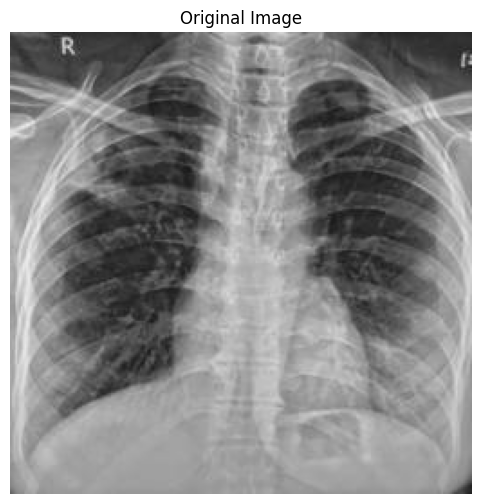

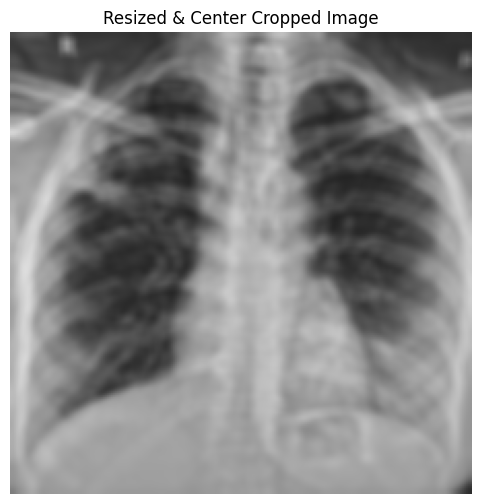

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

# Get the first image file path
img_path, _ = trainset.samples[900]  # Access raw file paths
original_img = Image.open("data_4_class/TB/TB.7.jpg")

# Show original image
plt.figure(figsize=(6,6))
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Apply the same transformations (without normalization, for better visualization)
visual_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=5, sigma=3) # Keep ToTensor to maintain format
])

# Transform the image
transformed_img = visual_transform(original_img)

# Convert back to NumPy for visualization
transformed_img = transformed_img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

# Show transformed image
plt.figure(figsize=(6,6))
plt.imshow(transformed_img)
plt.title("Resized & Center Cropped Image")
plt.axis("off")
plt.show()

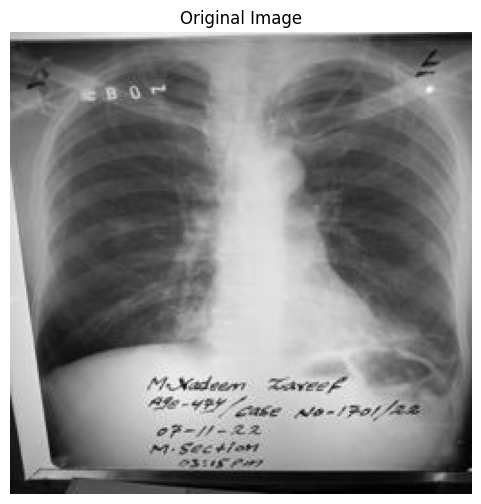

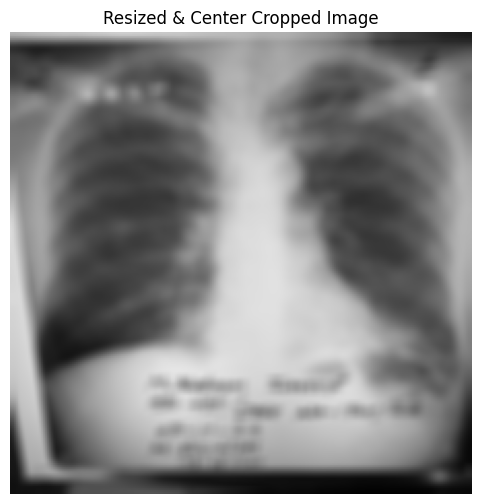

In [16]:

# Get the first image file path
img_path, _ = trainset.samples[900]  # Access raw file paths
original_img = Image.open("data_2_class/TB/TB.2265.jpg")

# Show original image
plt.figure(figsize=(6,6))
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Apply the same transformations (without normalization, for better visualization)
visual_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=7, sigma=3) # Keep ToTensor to maintain format
])

# Transform the image
transformed_img = visual_transform(original_img)

# Convert back to NumPy for visualization
transformed_img = transformed_img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

# Show transformed image
plt.figure(figsize=(6,6))
plt.imshow(transformed_img)
plt.title("Resized & Center Cropped Image")
plt.axis("off")
plt.show()